# ECBM 4040 - Assignment 1, Task 3: Dimensionality Reduction

Here is the third part and it is about dimentionality reduction. How to map high-dimentional data into low-dimensional space is an interesting topic in machine learning field. And also, it is related to another hot topic -- unsupervised learning. Now, in this section, you are going to learn two different methods for this question.

* Principal Component Analysis (PCA)
* t-Distributed Stochastic Neighbor Embedding (t-SNE) 

In [2]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from ecbm4040.cifar_utils import load_data

# Plot configurations
% matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

## Load Data

We will use the CIFAR-10 dataset.

In [3]:
# Load the raw CIFAR-10 data.
X_train, y_train, X_test, y_test = load_data()
X_train = X_train.reshape([50000,3,32,32]).transpose((0,2,3,1))
X_test = X_test.reshape([10000,3,32,32]).transpose((0,2,3,1))
# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# Data organizations:
# Train data: 49000 samples from original train set: 1~49000
# Validation data: 1000 samples from original train set: 49000~50000
# Test data: 10000 samples from original test set: 1~10000
# Development data (for gradient check): 100 from the train set: 1~49000 #TODOTA is this 100 or 1000

num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
(49000, 32, 32, 3) (1000, 32, 32, 3) (10000, 32, 32, 3) (100, 32, 32, 3)
Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
Development data shape: (100, 32, 32, 3)
Development data shape (100,)


## Part 1: Principal Component Analysis (PCA)

<span style="color:red"><strong>TODO</strong></span>: You have to complete the code in **./ecbm4040/features/pca.py**.

### Naive PCA

In [4]:
from ecbm4040.features.pca import pca_naive

X_patch = X_train[:,:,:,0]
X_patch = np.reshape(X_patch, (X_patch.shape[0], -1))
X_patch.shape

(49000, 1024)

In [5]:
# Start PCA
K = 200
P, T = pca_naive(X_patch, K)

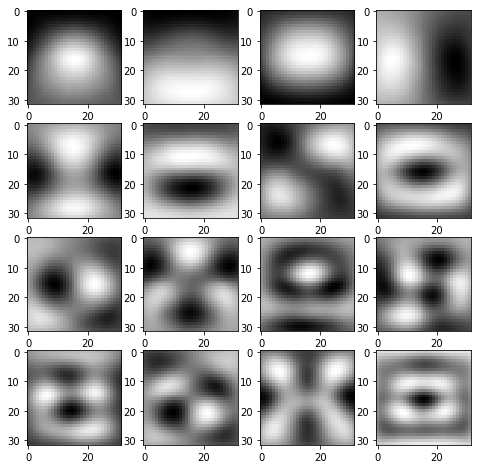

In [6]:
# TODO: Show principle components of P using a 4x4 subplot
# Visualize P
r = 4
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = np.reshape(P[r*i+j], [32,32])
        axarr[i][j].imshow(img, cmap="gray")

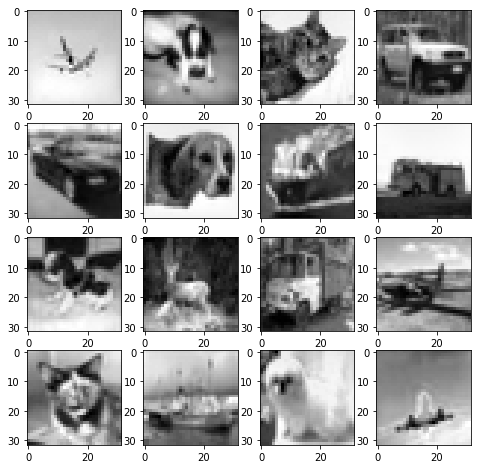

In [7]:
# Select a small set of images for test
num_training = 49000
num_pca = 16
mask = np.random.choice(num_training, num_pca, replace=False)
X_pca = X_train[mask,:,:,0]

# Visualize one channel of images 
r = 4
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = X_pca[r*i+j]
        axarr[i][j].imshow(img, cmap="gray")

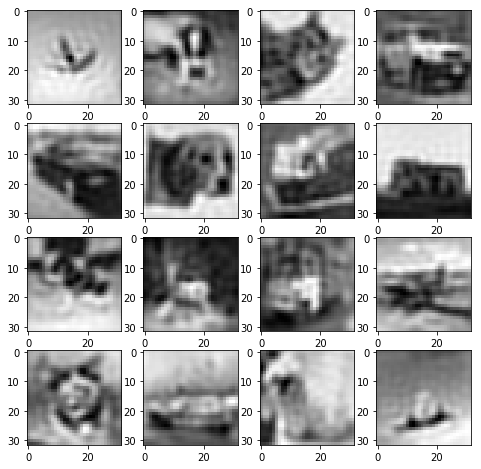

In [8]:
# TODO: Test your result
# Reduce dimension with P
X_features = []
for n in range(num_pca):
    img = X_pca[n]
    feature = np.dot(P, np.reshape(img, (-1,)))
    X_features.append(feature)

# Reconstruct image
X_recon = []
for n in range(num_pca):
    feature = X_features[n]
    img = np.reshape(np.dot(feature, P), (32,32))
    X_recon.append(img)

# Visualize results
r = 4
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = X_recon[r*i+j]
        axarr[i][j].imshow(img, cmap="gray")

### PCA + Neural network

<span style="color:red"><strong>TODO</strong></span>: Use PCA to preprocess images before training a neural network: 

1. Do PCA preprocessing on each channel of the original image separately.
2. Stack PCA features from three channels into one vector, and use that vector as an input for MLP.
3. Train the MLP and show the results. 

In [9]:
from ecbm4040.train_funcs import train, test
from ecbm4040.classifiers.mlp import MLP

# TODO: pca preprocessing -> mlp classification

K = 200

# Combine data and apply PCA preprocessing
y = np.concatenate((y_train, y_val,y_test), axis = 0)
X_patch1 = np.concatenate( (X_train[:,:,:,0], X_val[:,:,:,0], X_test[:,:,:,0]), axis = 0)
X_patch1 = np.reshape(X_patch1, (X_patch1.shape[0], -1))
P1, T1 = pca_naive(X_patch1, K)
X_patch1_rc = X_patch1.dot(P1.T) 

X_patch2 = np.concatenate( (X_train[:,:,:,1], X_val[:,:,:,1], X_test[:,:,:,1]), axis = 0)
X_patch2 = np.reshape(X_patch2, (X_patch2.shape[0], -1))
P2, T2 = pca_naive(X_patch2, K)
X_patch2_rc = X_patch2.dot(P2.T) 

X_patch3 = np.concatenate( (X_train[:,:,:,2], X_val[:,:,:,2], X_test[:,:,:,2]), axis = 0)
X_patch3 = np.reshape(X_patch3, (X_patch3.shape[0], -1))
P3, T3 = pca_naive(X_patch3, K)
X_patch3_rc = X_patch3.dot(P3.T) 


X_patch_train = np.concatenate((X_patch1_rc, X_patch2_rc, X_patch3_rc),axis = 1)



In [11]:
y.shape

(60000,)

In [12]:
# Splitting into train test and validation

X_test = X_patch_train[-10000:]
y_test = y[-10000:]

X_train = X_patch_train[:50000]
y_train = y[:50000]

X_val = X_train[-1000:]
y_val = y_train[-1000:]


X_train = X_train[:49000]
y_train = y_train[:49000]


In [13]:
model = MLP(input_dim=600, hidden_dims=[30, 30], num_classes=10, reg=0.001, weight_scale=1e-3)

num_epoch = 50
batch_size = 500
lr = 1e-2
verbose = True
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 98
5000/49000 loss: 2.302590511901665
10000/49000 loss: 2.302574101188382
15000/49000 loss: 2.3026157250947197
20000/49000 loss: 2.3025205906788675
25000/49000 loss: 2.302531803821676
30000/49000 loss: 2.30252590792867
35000/49000 loss: 2.3023955842807595
40000/49000 loss: 2.302320594715845
45000/49000 loss: 2.30218514480201
epoch 1: valid acc = 0.095, new learning rate = 0.0095
5000/49000 loss: 2.302230005343224
10000/49000 loss: 2.301255014742047
15000/49000 loss: 2.297222208800359
20000/49000 loss: 2.2509847524277995
25000/49000 loss: 2.224083940464686
30000/49000 loss: 2.204246696635547
35000/49000 loss: 2.142298730514797
40000/49000 loss: 2.1522866283038886
45000/49000 loss: 2.174126526220672
epoch 2: valid acc = 0.172, new learning rate = 0.009025
5000/49000 loss: 2.1571578839104535
10000/49000 loss: 2.141021853747577
15000/49000 loss: 2.124185970022752
20000/49000 loss: 2.176688513974979
25000/49000 loss: 2.1120580123598365
30000/49000 loss: 2.138

40000/49000 loss: 1.2721274408527552
45000/49000 loss: 1.3780850290172413
epoch 21: valid acc = 0.476, new learning rate = 0.0034056162628811476
5000/49000 loss: 1.3572445393843366
10000/49000 loss: 1.3161101249116758
15000/49000 loss: 1.313599760468164
20000/49000 loss: 1.3619984941709937
25000/49000 loss: 1.3011089204512716
30000/49000 loss: 1.300832893217684
35000/49000 loss: 1.3410442186824865
40000/49000 loss: 1.293259011409512
45000/49000 loss: 1.2700499525430118
epoch 22: valid acc = 0.476, new learning rate = 0.0032353354497370902
5000/49000 loss: 1.3440377031389525
10000/49000 loss: 1.3747262494624233
15000/49000 loss: 1.3447551531191855
20000/49000 loss: 1.310202956992861
25000/49000 loss: 1.278644865934898
30000/49000 loss: 1.2664374255973265
35000/49000 loss: 1.2794024976838727
40000/49000 loss: 1.2818013488315034
45000/49000 loss: 1.3403810205665894
epoch 23: valid acc = 0.476, new learning rate = 0.0030735686772502355
5000/49000 loss: 1.2161310537837924
10000/49000 loss: 

25000/49000 loss: 1.2314744243048354
30000/49000 loss: 1.2375834810805464
35000/49000 loss: 1.148085954994148
40000/49000 loss: 1.2174739316532353
45000/49000 loss: 1.2364604284533034
epoch 42: valid acc = 0.481, new learning rate = 0.0011598222130000551
5000/49000 loss: 1.2343062403002865
10000/49000 loss: 1.2781507237384584
15000/49000 loss: 1.2728594899560803
20000/49000 loss: 1.1429957014182692
25000/49000 loss: 1.1743990248831007
30000/49000 loss: 1.2019244866582637
35000/49000 loss: 1.2237869341300216
40000/49000 loss: 1.2906171851416126
45000/49000 loss: 1.1855044770171983
epoch 43: valid acc = 0.492, new learning rate = 0.0011018311023500522
5000/49000 loss: 1.2305999931312512
10000/49000 loss: 1.151722871399506
15000/49000 loss: 1.1917210734188102
20000/49000 loss: 1.2087847538728134
25000/49000 loss: 1.282009884901005
30000/49000 loss: 1.2511457719536023
35000/49000 loss: 1.2571794214717957
40000/49000 loss: 1.1613107615555838
45000/49000 loss: 1.247498105321712
epoch 44: val

0.49819999999999998

<span style="color:red"><strong>TODO</strong></span>: Plot training, validation and test set accuracy.

### Test accuracy of 49.8%

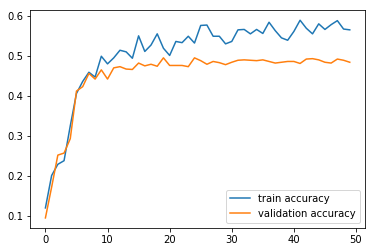

In [14]:
# TODO: plot training and validation accuracy

# plot the accuracy history
plt.plot(train_acc_hist, label="train accuracy")
plt.plot(val_acc_hist, label="validation accuracy")
plt.legend()
plt.show()

## Part 2: t-SNE (not graded)

t-SNE is is a machine learning algorithm for nonlinear dimensionality reduction developed by Geoffrey Hinton and Laurens van der Maaten. It is also a good way of visualizing high-dimensional data in 2D. We show its application for CIFAR10. Later it will be re-used in a CNN network. Experimenting with t-SNE can be fun. One thing to try is to visualize the output of each layer of MLP to observe the differences.

<p style="line-height: 1.2;">[1] Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of Machine Learning Research 9.Nov (2008): 2579-2605.</p>
<p style="line-height: 1.2;">[2] Adaptive learning rate scheme by Jacobs https://www.willamette.edu/~gorr/classes/cs449/Momentum/deltabardelta.html</p>
<p style="line-height: 1.2;">[3] http://cs.stanford.edu/people/karpathy/cnnembed/</p>
<p style="line-height: 1.2;">[4] How to Use t-SNE Effectively, with examples.
 https://distill.pub/2016/misread-tsne</p>

In [24]:
from ecbm4040.features.tsne import tsne

#### tSNE of original data

In [25]:
random_select = np.random.choice(10000, 500, replace=False)
X = X_test[random_select,:,:,0].reshape(500,1024).astype('float')/255.0
tic = time.time()
Y = tsne(X, low_dim=2, perplexity=30.0)
print("it takes {} seconds".format(time.time()-tic))

2.45613304454
The 100 th loop cost: 14.840343686232789, computation time: 3.3010706901550293
The 200 th loop cost: 1.1591205289799464, computation time: 6.584784507751465
The 300 th loop cost: 1.1557145838514171, computation time: 9.865872383117676
The 400 th loop cost: 1.1556734165417564, computation time: 13.152281999588013
The 500 th loop cost: 1.1556733202516027, computation time: 16.43044376373291
The 600 th loop cost: 1.1556733201604004, computation time: 19.716425895690918
The 700 th loop cost: 1.1556733201602558, computation time: 23.01303267478943
The 800 th loop cost: 1.1556733201602547, computation time: 26.295442819595337
The 900 th loop cost: 1.1556733201602545, computation time: 29.583944082260132
The 1000 th loop cost: 1.155673320160254, computation time: 33.06569790840149
it takes 34.83831024169922 seconds


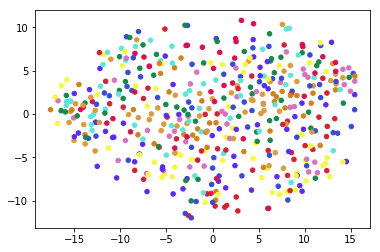

In [26]:
## visualize tSNE of original data
labels = y_test[random_select]
colors = np.random.rand(10,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#### tSNE of data after two hidden layers

In the visualization result, you should find that in comparison with the tSNE of original data where all data points mess up with each other, the tSNE of data after two-layer networks is shown as multiple clusters in a 2D panel.

In [28]:
# Define MLP model
model = MLP(input_dim=3072, hidden_dims=[100], num_classes=10, reg=0.1, weight_scale=1e-2)

num_epoch = 10
batch_size = 200
lr = 1e-3
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

In [ ]:
# run tSNE
X = X_test[random_select]
X = model.layers[0].feedforward(X)
X = model.layers[1].feedforward(X)
X_exp = np.exp(X)
X = X_exp / np.tile(np.sum(X_exp, axis=1, keepdims=True), 10)

tic = time.time()
Y = tsne(X, low_dim=2, perplexity=30.0)
print("it takes {} seconds".format(time.time()-tic))

In [ ]:
# visualize tSNE 2D representation of data after two hidden layers
labels = y_test[random_select]
colors = np.random.rand(10,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()